In [1]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import cv2
import random
import glob

In [2]:
os.chdir('D:/MACHINE_LEARNING/Bacteria/') #Image directory

In [3]:
path =  os.getcwd() 

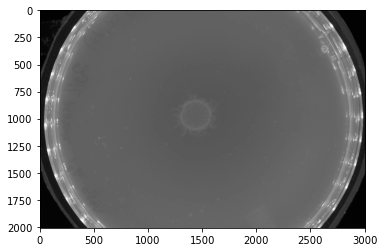

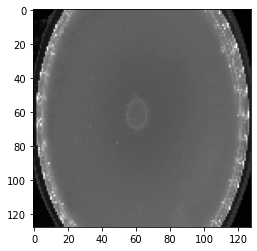

In [4]:
for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break
    
IMG_SIZE = 128

#Display the Resized image

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [5]:
train_data = []

#Data creation this miight take some time to run so be patient

def create_data():
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            train_data.append(new_array)
        except Exception as e:
                pass
create_data()

In [5]:
#Resizing the data

train_data = np.array(train_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(len(train_data))
train_data = train_data/255.0
print(train_data[0][10])

NameError: name 'train_data' is not defined

In [7]:
type(train_data[0])

numpy.ndarray

In [8]:
train_data[0].shape

(128, 128, 1)

In [9]:
print(train_data[0].shape)
print(type(train_data))

(128, 128, 1)
<class 'numpy.ndarray'>


In [5]:
#Storing the data in pickle so that we wont have to create data everytime we run this code
import pickle

pickle_out = open("train_data.pickle", "wb")
pickle.dump(train_data, pickle_out)
pickle_out.close()

In [6]:
import pickle

pickle_in = open("train_data.pickle", "rb")
X =  pickle.load(pickle_in)
# X = X/255.0
x_train = X
train_data = X
print(X)

[[[[0.01960784]
   [0.02352941]
   [0.02352941]
   ...
   [0.01568627]
   [0.01960784]
   [0.01960784]]

  [[0.01960784]
   [0.02352941]
   [0.01960784]
   ...
   [0.01960784]
   [0.02352941]
   [0.01960784]]

  [[0.01960784]
   [0.01960784]
   [0.01960784]
   ...
   [0.01960784]
   [0.01960784]
   [0.01568627]]

  ...

  [[0.02745098]
   [0.02745098]
   [0.02745098]
   ...
   [0.02352941]
   [0.02352941]
   [0.02352941]]

  [[0.02745098]
   [0.03137255]
   [0.03529412]
   ...
   [0.02352941]
   [0.02352941]
   [0.02352941]]

  [[0.02745098]
   [0.03137255]
   [0.03137255]
   ...
   [0.02352941]
   [0.01960784]
   [0.01568627]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0. 

In [7]:
def plotImages(images_arr):
    fig, axes =  plt.subplots(1, 10, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

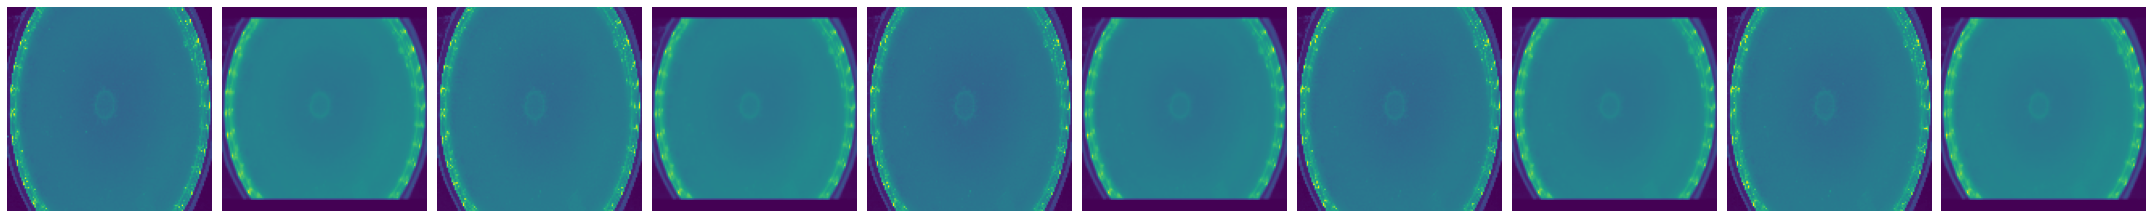

In [8]:
plotImages(train_data)

In [9]:
print(train_data.shape[2])

# Reshape 
img_width  = train_data.shape[1]
img_height = train_data.shape[2]
num_channels = 1
x_train = train_data.reshape(train_data.shape[0], img_height, img_width, num_channels)

input_shape = (img_height, img_width, num_channels)
print(input_shape)

128
(128, 128, 1)


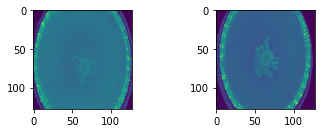

In [10]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

In [32]:
# BUILD THE MODEL

latent_dim = 2048 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(64, 3, padding='same', activation='relu')(input_img)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Dropout(0.2)(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

# ================= ###########
# Decoder
#
# ================= #################

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 64) 640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 64, 64, 64)   0           max_pooling2d_9[0][0]            
____________________________________________________________________________________________

In [33]:

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

In [34]:
# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
# vae.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 64) 640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 64, 64, 64)   0           max_pooling2d_9[0][0]            
________________________________________________________________________________________________

In [ ]:
vae.fit(x_train, None, epochs = 30, batch_size = 32, validation_split = 0.2)

Train on 385 samples, validate on 97 samples
Epoch 1/30


In [ ]:
X = train_data

In [ ]:
plt.imshow(np.array(X[99]), cmap='gray')

In [ ]:
ae_out = encoder.predict(np.array(X[99]).reshape(-1,128,128,1))[0]
print(ae_out)

In [ ]:
decoded_example = decoder.predict(np.array([ae_out[0]]))
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped, cmap='gray')